Load necessary libraries

In [54]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from mordred import Calculator, descriptors
from rdkit import Chem
from sklearn.utils import shuffle
import pandas as pd
import numpy as np

First, load the full subset of QM9 available through our GitHub and compute features using Mordred. You will need to convert all data to a float (see DataFrame.astype) and drop missing values, but do not use any other dimensionality reduction. Once complete, make a test set of 2000 molecules

In [2]:
data = pd.read_json('../datasets/qm9.json.gz', lines=True)  # Do not need the full set to make a point.
print(f'Loaded {len(data)} molecules')

Loaded 25000 molecules


In [3]:
data['mol'] = data['smiles_0'].apply(Chem.MolFromSmiles)
calc = Calculator(descriptors, ignore_3D=True)
desc = calc.pandas(data['mol'])

100%|██████████| 25000/25000 [05:20<00:00, 77.92it/s] 


In [4]:
print(f'Computed {len(desc.columns)} descriptors for {len(desc)} molecules')

Computed 1613 descriptors for 25000 molecules


Convert all the data to float

In [6]:
for column in desc.columns:
    desc[column] = pd.to_numeric(desc[column], errors='coerce')

In [7]:
missing_values = desc.isnull().any()
print(f'Found {missing_values.sum()} columns with missing values')

Found 546 columns with missing values


In [8]:
desc = desc.loc[:, ~missing_values]  # Gets only rows that do not (~ means not) have missing values
print(f'New shape: {desc.shape}')

New shape: (25000, 1067)


make a test set of 2000 molecules

In [13]:
train_data, test_data, train_desc, test_desc = train_test_split(data, desc, test_size=0.08)

In [20]:
train_data_sets = []
train_desc_sets = []
train_set_sizes = [10, 100, 1000, 10000]
for t in train_set_sizes:
    train_data_, train_desc_ = shuffle(train_data, train_desc, n_samples=t)
    train_data_sets.append(train_data_)
    train_desc_sets.append(train_desc_)

Train a LassoCV model using the features ***with*** reducing the dimensionality to 8 features using PCA

In [34]:
model_with_pca = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=8)),
    ('lasso', LassoCV())
])

In [46]:
results = []
test_data = test_data.copy()  # Avoids some pandas issues
for index, t in enumerate(train_set_sizes):
    test_data['8-ncomp-model-'+str(t)] = model_with_pca.fit(train_desc_sets[index], train_data_sets[index]['bandgap']).predict(test_desc)
    results.append({
                'train_size': t,
                'mae': mean_absolute_error(test_data['bandgap'], test_data['8-ncomp-model-'+str(t)])
            })
results = pd.DataFrame(results)

Train a LassoCV model using the features ***without*** reducing the dimensionality to 8 features using PCA

In [47]:
model_without_pca = Pipeline([
    ('scale', StandardScaler()),
    ('lasso', LassoCV(max_iter=10000)) # When max_iter is set to default (1000), the model would not converge
])

In [49]:
results_without = []
test_data = test_data.copy()  # Avoids some pandas issues
for index, t in enumerate(train_set_sizes):
    test_data['without-ncomp-model-'+str(t)] = model_without_pca.fit(train_desc_sets[index], train_data_sets[index]['bandgap']).predict(test_desc)
    results_without.append({
                'train_size': t,
                'mae': mean_absolute_error(test_data['bandgap'], test_data['without-ncomp-model-'+str(t)])
            })
results_without = pd.DataFrame(results_without)

In [55]:
model_RFR = Pipeline([
    ('scale', StandardScaler()),
    ('randomforest', RandomForestRegressor())
])

In [56]:
results_RFR = []
test_data = test_data.copy()  # Avoids some pandas issues
for index, t in enumerate(train_set_sizes):
    test_data['RFR-default-model-'+str(t)] = model_RFR.fit(train_desc_sets[index], train_data_sets[index]['bandgap']).predict(test_desc)
    results_RFR.append({
                'train_size': t,
                'mae': mean_absolute_error(test_data['bandgap'], test_data['RFR-default-model-'+str(t)])
            })
results_RFR = pd.DataFrame(results_RFR)

Plot the change in mean absolute error (MAE) with respect to training set sizes: 10, 100, 1000, 10000. 

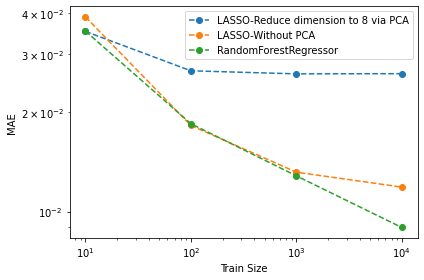

In [57]:
fig, ax = plt.subplots()
ax.loglog(train_set_sizes, results['mae'], '--o', label="LASSO-Reduce dimension to 8 via PCA")
ax.loglog(train_set_sizes, results_without['mae'], '--o', label="LASSO-Without PCA")
ax.loglog(train_set_sizes, results_RFR['mae'], '--o', label="RandomForestRegressor")
ax.legend()

ax.set_xlabel('Train Size')
ax.set_ylabel('MAE')
fig.tight_layout()

The graph above showed that for LASSO model, when the features' dimention is reduced to 8, MAE would not decrease at large training size, while two other model (LASSO without PCA and RandomForestRegression) would continue to increase accuracy. There are two reasons that lead to the result. 

- Let's focus on the behaviors of two LASSO methods first. When training features are set to limited number (e.g. 8), model can be easily trained and even become overfitting with small amount of training data, while models with large sets of features don't. In that case, ***LASSO-Without PCA*** would continue converging, while ***LASSO-Reduce dimension to 8 via PCA*** stop converging at large training size.
- What's more, the nature of algorithm really matters. ***RandomForestRegression*** is based on RandomTree Algorithm, which is actually a decision tree for one feature. ***RandomForestRegression*** generates tens of thousands of RandomTrees to deal with lots of features independently and parellely. In that case, ***RandomForestRegression*** is considered as one of the best ML algorithms that can deal with high-demensional data or many-feature data. However, ***LASSO*** is just a Linear Regression algorithm, which means that dealing with high-dimentional data is not ***LASSO***'s strength. That's the reason why ***RandomForestRegression*** performs better that ***LASSO*** at large training size.